In [33]:
import numpy as np
import matplotlib.pyplot as plt
import os
import skimage
import pickle
from PIL import Image
from sklearn.model_selection import train_test_split

import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms
from torchvision.utils import make_grid, save_image

print('PyTorch version:', torch.__version__)
print('torchvision version:', torchvision.__version__)
use_gpu = torch.cuda.is_available()
print('Is GPU available:', use_gpu)

PyTorch version: 0.4.1
torchvision version: 0.2.1
Is GPU available: True


In [3]:
# general settings

# device
device = torch.device('cuda' if use_gpu else 'cpu')

# batchsize (same as AVID paper)
batchsize = 16

# seed setting (warning : cuDNN's randomness is remaining)
seed = 1
torch.manual_seed(seed)
if use_gpu:
    torch.cuda.manual_seed(seed)
    
# directory settings
# Data directory (for IR-MNIST)
data_dir = '../../data/IR-MNIST/'
train_data_dir = data_dir + 'Train_Samples/'
test_data_dir = data_dir + 'Test_Samples/'

# directory to put generated images
output_dir = data_dir + 'output/'
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
    
# directory to save state_dict and loss.npy
save_dir = data_dir + 'save/'
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

In [4]:
# make dataset class for image loading
class MyDataset(Dataset):
    def __init__(self, root_dir, transform = None):
        self.root_dir = root_dir
        self.list_dir = os.listdir(root_dir)
        self.transform = transform
        
    def __len__(self):
        return len(self.list_dir)
    
    def __getitem__(self, idx):
        img_name = self.root_dir + self.list_dir[idx]
        image = skimage.io.imread(img_name)
        
        if self.transform:
            image = self.transform(image)
            
        return image

In [5]:
# define transform
# Normalize [0~255] to [-1~1]
class Normalize:
    def __call__(self, image):
        return (image - 127.5) / 127.5
    
class Tofloat:
    def __call__(self, tensor):
        return tensor.float()
    
tf = transforms.Compose([Normalize(), transforms.ToTensor(), Tofloat()])

In [6]:
# make dataset
imgDataset = MyDataset(train_data_dir, transform = tf)

# split to train data and validation data
train_data, validation_data = train_test_split(imgDataset, test_size = 0.2, random_state = seed)

print('The number of training data:', len(train_data))
print('The number of validation data:', len(validation_data))

The number of training data: 4000
The number of validation data: 1000


In [7]:
# make DataLoader
train_loader = DataLoader(train_data, batch_size = batchsize, shuffle = True)
validation_loader = DataLoader(validation_data, batch_size = batchsize, shuffle = True)

torch.Size([3, 224, 224])


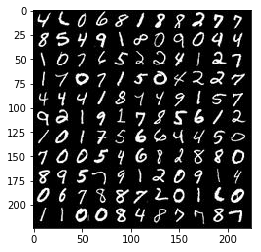

In [81]:
# visualization of an example of training data
# comment out when runnnig in no GUI machine
def show_image(tensor_image):
    np_image = tensor_image.numpy()
    np_image = np.transpose(np_image, [1, 2, 0]) * 0.5 + 0.5
    plt.imshow(np_image)
    
X = iter(train_loader).next()[0]
print(X.size())
show_image(X)

In [44]:
# define parts for U-net and FCN for convenience
# downsampling
# conv > batchnorm > dropout > leakyrelu
class Downsample(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size = 4 , stride = 2, padding = 1, \
                                                                    use_batchnorm = True, use_dropout = False):
        super(Downsample, self).__init__()
        self.cv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.dr = nn.Dropout(0.5)
        self.rl = nn.LeakyReLU(0.2)
        
        self.use_batchnorm = use_batchnorm
        self.use_dropout = use_dropout
        
    def forward(self, x):
        out = self.cv(x)
        
        if self.use_batchnorm:
            out = self.bn(out)
            
        if self.use_dropout:
            out = self.dr(out)
            
        out = self.rl(out)
        
        return out

In [45]:
# define parts for U-net for convenience
# upsampling (using transposed convolution)
# conv > batchnorm > dropout > relu
class Upsample(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size = 4, stride = 2, padding = 1, \
                                                                   use_batchnorm = True, use_dropout = False):
        super(Upsample, self).__init__()
        self.tc = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.dr = nn.Dropout(0.5)
        self.rl = nn.ReLU()
        
        self.use_batchnorm = use_batchnorm
        self.use_dropout = use_dropout
        
    def forward(self, x):
        out = self.tc(x)
        
        if self.use_batchnorm:
            out = self.bn(out)
            
        if self.use_dropout:
            out = self.dr(out)
            
        out = self.rl(out)
        
        return out

In [153]:
''' Memo : CNN size equation (no dilation)

                                OUT = (IN + 2*Padding - Kernel_size) / Stride + 1                 
'''
# define Inpainter (Generator for GAN)
# U-net architecture
class Inpainter(nn.Module):
    def __init__(self):
        super(Inpainter, self).__init__()
        
        # U-net encoder
        # default: kernel_size = 4, stride = 2, padding = 1, using batchnorm, no dropout
        self.encoder1 = Downsample(  3,  32, use_batchnorm = False)   # out tensor size: (batchsize,  32, 112, 112)
        self.encoder2 = Downsample( 32,  64)                          # out tensor size: (batchsize,  64,  56,  56)
        self.encoder3 = Downsample( 64, 128)                          # out tensor size: (batchsize, 128,  28,  28)
        self.encoder4 = Downsample(128, 256)                          # out tensor size: (batchsize, 256,  14,  14)
        self.encoder5 = Downsample(256, 512)                          # out tensor size: (batchsize, 512,   7,   7)
        
        # U-net decoder
        # default: kernel_size = 4, stride = 2, padding = 1, using batchnorm, no dropout
        self.decoder1 = Upsample(512    , 512)                        # out tensor size: (batchsize, 512,  14,  14)
        self.decoder2 = Upsample(512+256, 512)                        # out tensor size: (batchsize, 512,  28,  28)
        self.decoder3 = Upsample(512+128, 256)                        # out tensor size: (batchsize, 256,  56,  56)
        self.decoder4 = Upsample(256+ 64, 128)                        # out tensor size: (batchsize, 128, 112, 112)
        self.decoder5 = Upsample(128+ 32,  64)                        # out tensor size: (batchsize,  64, 224, 224)
        
        # pointwise convolution to adjust channel with no image size change
        self.decoder_final = nn.Conv2d(64, 3, kernel_size = 1, stride = 1, padding = 0)
        self.th = nn.Tanh()
        
    def forward(self, x):
        # encoding part
        out_encoder1 = self.encoder1(x)
        out_encoder2 = self.encoder2(out_encoder1)
        out_encoder3 = self.encoder3(out_encoder2)
        out_encoder4 = self.encoder4(out_encoder3)
        out_encoder5 = self.encoder5(out_encoder4)
        
        # decording part
        out_decoder1 = self.decoder1(out_encoder5)
        out_decoder2 = self.decoder2(torch.cat([out_decoder1, out_encoder4], dim = 1))
        out_decoder3 = self.decoder3(torch.cat([out_decoder2, out_encoder3], dim = 1))
        out_decoder4 = self.decoder4(torch.cat([out_decoder3, out_encoder2], dim = 1))
        out_decoder5 = self.decoder5(torch.cat([out_decoder4, out_encoder1], dim = 1))
        
        out = self.decoder_final(out_decoder5)
        out = self.th(out)
        
        return out

In [173]:
''' Memo : CNN size equation (no dilation)

                                OUT = (IN + 2*Padding - Kernel_size) / Stride + 1                 
'''
# define Detector (Discriminator for GAN)
# FCN-architecture (PatchGAN discriminator)
''' Issue : Should we condition discriminator by input Image? '''
class Detector(nn.Module):
    def __init__(self):
        super(Detector, self).__init__()
        # default: kernel_size = 4, stride = 2, padding = 1, using batchnorm, no dropout
        self.fcn1x = Downsample(  3,  32, use_batchnorm = False)   # out tensor size: (batchsize,  32, 112, 112)
        self.fcn1y = Downsample(  3,  32, use_batchnorm = False)   # out tensor size: (batchsize,  32, 112, 112)
        self.fcn2  = Downsample( 64,  64)                          # out tensor size: (batchsize,  64,  56,  56)
        self.fcn3  = Downsample( 64, 128)                          # out tensor size: (batchsize, 128,  28,  28)
        self.fcn4  = Downsample(128, 256)                          # out tensor size: (batchsize, 256,  14,  14)
        self.fcn5  = Downsample(256, 512, stride = 1, padding = 0) # out tensor size: (batchsize, 512,  11,  11)
        
        # pointwise convolution to adjust channel with no image size change
        self.fcn_final = nn.Conv2d(512, 1, kernel_size = 1, stride = 1, padding = 0)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, y):
        # input x:Inpainter output, y:original image for conditioning
        out_x = self.fcn1x(x)
        out_y = self.fcn1y(y)
        out = torch.cat([out_x, out_y], dim = 1)
        
        out = self.fcn2(out)
        out = self.fcn3(out)
        out = self.fcn4(out)
        out = self.fcn5(out)
        
        out = self.fcn_final(out)
        out = self.sigmoid(out)
        
        return out

In [174]:
# network, optimizer and hyperparameters settings

# instantiate networks
inpainter = Inpainter()
detector = Detector()

# send to GPU(CPU)
inpainter = inpainter.to(device)
detector = detector.to(device)

# set optimizer
inp_optimizer = optim.Adam(inpainter.parameters(), lr = 0.0002, betas = [0.5, 0.999])
det_optimizer = optim.Adam(detector.parameters(), lr = 0.0002, betas = [0.5, 0.999])

# init weights
for p in inpainter.parameters():
    nn.init.normal_(p, mean = 0, std = 0.02)
    
for p in detector.parameters():
    nn.init.normal_(p, mean = 0, std = 0.02)

# count the number of trainable parameters
num_trainable_params_inp = sum(p.numel() for p in inpainter.parameters() if p.requires_grad)
num_trainable_params_det = sum(p.numel() for p in detector.parameters() if p.requires_grad)

In [175]:
# print settings

print('--------------------------------------------------------------------------------------')
print('Inpainter')
print('The number of trainable parameters:', num_trainable_params_inp)
print('\nModel\n', inpainter)
print('\nOptimizer\n', inp_optimizer)

print('--------------------------------------------------------------------------------------')
print('Detector')
print('The number of trainable parameters:', num_trainable_params_det)
print('\nModel\n', detector)
print('\nOptimizer\n', det_optimizer)

--------------------------------------------------------------------------------------
Inpainter
The number of trainable parameters: 16720803

Model
 Inpainter(
  (encoder1): Downsample(
    (cv): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dr): Dropout(p=0.5)
    (rl): LeakyReLU(negative_slope=0.2)
  )
  (encoder2): Downsample(
    (cv): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dr): Dropout(p=0.5)
    (rl): LeakyReLU(negative_slope=0.2)
  )
  (encoder3): Downsample(
    (cv): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (dr): Dropout(p=0.5)
    (rl): LeakyReLU(negative_slope=0.2)
  )
  (encoder4): Downsample(
    (cv): Conv2d(128, 256, ke

In [176]:
# define loss function
λ = 100
def inp_loss(det_output_fake, inp_output, input_image):
    adversarial_loss = F.binary_cross_entropy(det_output_fake, torch.ones_like(det_output_fake))
    # l1_loss = F.l1_loss(inp_output, input_image)
    return adversarial_loss # + λ * l1_loss
def det_loss(det_output_real, det_output_fake):
    real_loss = F.binary_cross_entropy(det_output_real, torch.ones_like(det_output_real))
    fake_loss = F.binary_cross_entropy(det_output_fake, torch.zeros_like(det_output_fake))
    adversarial_loss = 0.5 * (real_loss + fake_loss) # devide by 2 to regulate learning speed (mentioned by pix2pix)
    return adversarial_loss

In [177]:
def train(data_loader):
    inpainter.train()
    detector.train()
    
    running_inpainter_loss = 0
    running_detector_loss = 0
    
    for inputs in data_loader:
        inputs = inputs.to(device)
        # make contaminated inputs for inpainter network by adding gaussian noise
        inputs_contaminated = inputs + γ * torch.randn(inputs.size()).to(device)
        
        # calculate network outputs
        inp_outputs = inpainter(inputs_contaminated)
        det_outputs_real = detector(inputs, inputs_contaminated)
        # .detach() is used not to track inpainter gradient during detector backward calculation
        det_outputs_fake_for_det = detector(inp_outputs.detach(), inputs_contaminated)
        det_outputs_fake_for_inp = detector(inp_outputs, inputs_contaminated)
        
        # detector : calculate loss function, run backward calculation, and update weights
        det_optimizer.zero_grad()
        detector_loss = det_loss(det_outputs_real, det_outputs_fake_for_det)
        detector_loss.backward()
        det_optimizer.step()
        
        # inpainter : calculate loss function, run backward calculation, and update weights
        inp_optimizer.zero_grad()
        inpainter_loss = inp_loss(det_outputs_fake_for_inp, inp_outputs, inputs)
        inpainter_loss.backward()
        inp_optimizer.step()
        
        # extract number from zero dimension tensor by .item()
        running_inpainter_loss += inpainter_loss.item()
        running_detector_loss += detector_loss.item()
        
    # devide by len(data_loader) because F.binary_cross_entropy normalize loss in minibatch
    average_inpainter_loss = running_inpainter_loss / len(data_loader)
    average_detector_loss = running_detector_loss / len(data_loader)
    
    return average_inpainter_loss, average_detector_loss

In [178]:
n_save_images = 5
interval_save_images = 1 # epoch

def validation(data_loader, epoch):
    inpainter.train()
    detector.train()
    
    running_inpainter_loss = 0
    running_detector_loss = 0
    
    with torch.no_grad():
        for inputs in data_loader:
            inputs = inputs.to(device)
            inputs_contaminated = inputs + γ * torch.randn(inputs.size()).to(device)

            # calculate network outputs
            # some code that needn't for validation is deleted from train()
            inp_outputs = inpainter(inputs_contaminated)
            det_outputs_real = detector(inputs, inputs_contaminated)
            det_outputs_fake = detector(inp_outputs, inputs_contaminated)
            
            running_detector_loss += det_loss(det_outputs_real, det_outputs_fake).item()
            running_inpainter_loss += inp_loss(det_outputs_fake, inp_outputs, inputs).item()
            
    # save [n_save_images] (normal image, contaminated image, inpainted image) comparison image
    if epoch % interval_save_images == 0:
        for n in range(n_save_images):
            normal_image = inputs[n].unsqueeze(0)
            contaminated_image = inputs_contaminated[n].unsqueeze(0)
            inpainted_image = inp_outputs[n].unsqueeze(0)
            comparison = torch.cat([normal_image, contaminated_image, inpainted_image])
            save_image(comparison.data.cpu(), '{}/{}_{}.png'.format(output_dir, epoch, n))
                    
    average_inpainter_loss = running_inpainter_loss / len(data_loader)
    average_detector_loss = running_detector_loss / len(data_loader)
    
    return average_inpainter_loss, average_detector_loss

In [179]:
# coefficient for gaussian noise to add to inpainter input
γ = 0.7
n_epochs = 20
train_loss_list = [[], []]
validation_loss_list = [[], []]

for epoch in range(n_epochs):
    train_inp_loss, train_det_loss = train(train_loader)
    validation_inp_loss, validation_det_loss = validation(validation_loader, epoch)
    
    train_loss_list[0].append(train_inp_loss)
    train_loss_list[1].append(train_det_loss)
    validation_loss_list[0].append(validation_inp_loss)
    validation_loss_list[1].append(validation_det_loss)
    
    print('epoch[%d/%d] losses[train_inp:%1.4f train_det:%1.4f  validation_inp:%1.4f validation_det:%1.4f]' \
                        % (epoch+1, n_epochs, train_inp_loss, train_det_loss, validation_inp_loss, validation_det_loss)) 

# save state_dicts
torch.save(inpainter.state_dict(), save_dir + 'inpainter_' + str(epoch) + '.pth')
torch.save(detector.state_dict(), save_dir + 'detector_' + str(epoch) + '.pth')
torch.save(inp_optimizer.state_dict(), save_dir + 'inp_optmizer_' + str(epoch) + '.pth')
torch.save(det_optimizer.state_dict(), save_dir + 'det_discriminator' + str(epoch) + '.pth')

# save learning log
np.save(save_dir + 'train_loss_list.npy', np.array(train_loss_list))
np.save(save_dir + 'validation_loss_list.npy', np.array(validation_loss_list))

epoch[1/20] losses[train_inp:0.7991 train_det:0.6004  validation_inp:0.9808 validation_det:0.4634]
epoch[2/20] losses[train_inp:1.3133 train_det:0.3188  validation_inp:1.6946 validation_det:0.1984]
epoch[3/20] losses[train_inp:1.3332 train_det:0.3851  validation_inp:0.5672 validation_det:0.6668]
epoch[4/20] losses[train_inp:0.7829 train_det:0.6531  validation_inp:0.6867 validation_det:0.7504]
epoch[5/20] losses[train_inp:0.7221 train_det:0.6799  validation_inp:0.6745 validation_det:0.6963]
epoch[6/20] losses[train_inp:0.7239 train_det:0.6815  validation_inp:0.9000 validation_det:0.6143]
epoch[7/20] losses[train_inp:0.7410 train_det:0.6711  validation_inp:0.8478 validation_det:0.6449]
epoch[8/20] losses[train_inp:0.7327 train_det:0.6768  validation_inp:0.7664 validation_det:0.6879]
epoch[9/20] losses[train_inp:0.7269 train_det:0.6784  validation_inp:0.8277 validation_det:0.6871]
epoch[10/20] losses[train_inp:0.7307 train_det:0.6757  validation_inp:0.4736 validation_det:0.7260]
epoch[11/

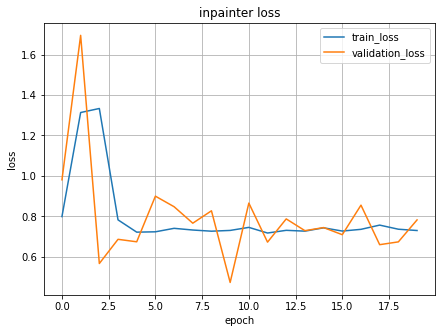

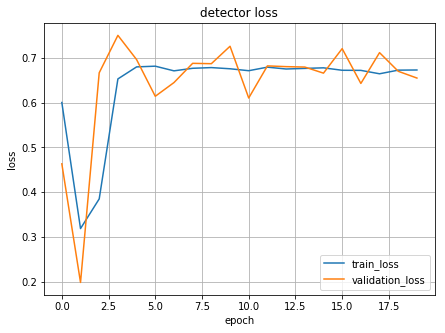

In [180]:
# check learning log

# load learning log
train_loss_list = np.load(save_dir + 'train_loss_list.npy')
validation_loss_list = np.load(save_dir + 'validation_loss_list.npy')

# inpainter loss
plt.figure(figsize = (7, 5))
plt.plot(train_loss_list[0], label = 'train_loss')
plt.plot(validation_loss_list[0], label = 'validation_loss')
plt.title('inpainter loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.show()

# detector loss
plt.figure(figsize = (7, 5))
plt.plot(train_loss_list[1], label = 'train_loss')
plt.plot(validation_loss_list[1], label = 'validation_loss')
plt.title('detector loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.show()

In [182]:
# prepare test data (apply same preprocessing)
testDataset = MyDataset(test_data_dir, transform = tf)
n_testdata = len(testDataset)
test_loader = DataLoader(testDataset, batch_size = batchsize, shuffle = False)

print('The number of test data:', n_testdata)

The number of test data: 1050


In [183]:
with torch.no_grad():
    test_data = iter(test_loader).next().to(device)
    test_data_contaminated = test_data + γ * torch.randn(test_data.size()).to(device)
    inp_outputs = inpainter(test_data_contaminated)
    det_outputs = detector(inp_outputs, test_data_contaminated)

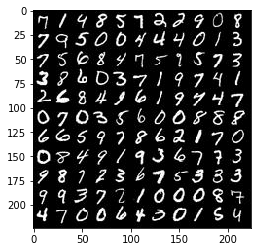

In [151]:
index = 0
show_image(test_data[index].data.cpu())

tensor([[[0.5544, 0.5434, 0.5957, 0.6109, 0.5580, 0.5606, 0.5310, 0.5746,
          0.5741, 0.5554, 0.5618],
         [0.5511, 0.5376, 0.6041, 0.6077, 0.5416, 0.5384, 0.5013, 0.5789,
          0.5866, 0.5733, 0.5298],
         [0.5557, 0.5065, 0.5809, 0.5842, 0.5195, 0.5284, 0.4885, 0.5905,
          0.6119, 0.6005, 0.5418],
         [0.5514, 0.4840, 0.5542, 0.5769, 0.5205, 0.5316, 0.5100, 0.5941,
          0.6160, 0.5876, 0.5461],
         [0.5594, 0.4944, 0.5344, 0.5521, 0.5064, 0.5346, 0.5210, 0.6020,
          0.6047, 0.5626, 0.5458],
         [0.5511, 0.5153, 0.5415, 0.5367, 0.4824, 0.5168, 0.5180, 0.6005,
          0.6146, 0.5671, 0.5523],
         [0.5641, 0.5108, 0.5518, 0.5444, 0.4880, 0.5043, 0.5000, 0.5125,
          0.5400, 0.4945, 0.5522],
         [0.5710, 0.5198, 0.5653, 0.5620, 0.4932, 0.5233, 0.5124, 0.5015,
          0.5140, 0.4486, 0.5606],
         [0.5694, 0.4961, 0.5639, 0.5471, 0.4988, 0.5414, 0.5272, 0.4904,
          0.5146, 0.4465, 0.5616],
         [0.5548, 0

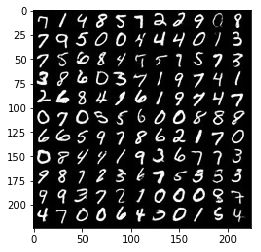

In [152]:
print(det_outputs[index])
show_image(inp_outputs[index].data.cpu())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


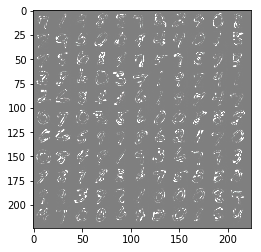

In [141]:
show_image((inp_outputs[index] - test_data[index]).pow(2).data.cpu())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


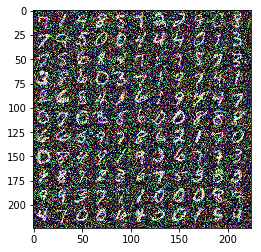

In [123]:
show_image(test_data_contaminated[0].data.cpu())

In [35]:
ground_truth_file = test_data_dir + 'ground_truth.pkl'
with open (ground_truth_file, 'rb') as f:
    ground_truth = pickle.load(f)

In [36]:
ground_truth

[array([[0., 4., 3., 5., 0., 6., 5., 1., 8., 9., 9.],
        [5., 8., 5., 9., 4., 2., 8., 6., 2., 6., 8.],
        [5., 6., 9., 4., 4., 8., 4., 8., 9., 0., 3.],
        [7., 2., 4., 0., 4., 2., 5., 1., 6., 1., 0.],
        [1., 7., 1., 6., 7., 4., 4., 7., 4., 1., 6.],
        [7., 6., 3., 5., 9., 5., 7., 1., 8., 5., 6.],
        [3., 4., 1., 5., 8., 4., 7., 0., 5., 9., 7.],
        [9., 7., 1., 8., 3., 5., 0., 7., 5., 6., 8.],
        [8., 6., 7., 2., 3., 3., 5., 1., 1., 1., 7.],
        [6., 5., 8., 3., 7., 4., 2., 8., 8., 8., 2.],
        [6., 1., 9., 6., 5., 1., 7., 3., 9., 2., 7.]]),
 array([[3., 9., 9., 4., 8., 4., 1., 3., 8., 6., 6.],
        [8., 3., 5., 2., 0., 7., 1., 3., 7., 0., 7.],
        [2., 2., 5., 2., 4., 7., 4., 4., 9., 6., 5.],
        [9., 9., 4., 2., 1., 0., 8., 6., 0., 3., 7.],
        [8., 0., 4., 1., 8., 2., 8., 6., 2., 1., 3.],
        [1., 9., 7., 3., 4., 3., 0., 9., 3., 5., 6.],
        [1., 1., 5., 6., 8., 1., 0., 4., 1., 9., 5.],
        [1., 0., 2., 5., 8